<a href="https://colab.research.google.com/github/ArtyomShabunin/SMOPA/blob/main/lesson_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://prana-system.com/files/110/rds_color_full.png" alt="tot image" width="300"  align="center"/> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;
<img src="https://mpei.ru/AboutUniverse/OficialInfo/Attributes/PublishingImages/logo1.jpg" alt="mpei image" width="200" align="center"/>
<img src="https://mpei.ru/Structure/Universe/tanpe/structure/tfhe/PublishingImages/tot.png" alt="tot image" width="100"  align="center"/>

---

# **Системы машинного обучения и предиктивной аналитики в тепловой и возобновляемой энергетике**  

# ***Практические занятия***


---



# Занятие №2
# Анализ и предобработка данных для обучения модели поиска аномалий
**26 февраля 2025г.**

---

## Импорты и вспомогательные функции

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
import seaborn as sns
sns.set_theme(rc={'figure.figsize':(15,5)})

from tqdm import tqdm
import glob
import json

import ipywidgets as widgets
from IPython.display import display, clear_output
import plotly.graph_objs as go

pd.options.mode.chained_assignment = None

from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

вспомогательные функции

In [ ]:
def select_bad_data_plot(x, y):

    layout = dict(
            margin=dict(
            t=30, # top
            b=10, # bottom
            l=10, # left
            r=10, # right
        )
    )

    color = np.zeros(x.shape[0])

    marker = go.scatter.Marker(color = color,
                               colorscale = [[0, 'blue'], [1, 'red']])

    fig = go.FigureWidget([
        go.Scatter(x = x, y = y,
        mode = 'markers',
        marker = marker)
    ], layout=layout)


    def brush(trace, points, state):
        inds = np.array(points.point_inds)
        if inds.size:
            color[inds] = (~color[inds].astype(bool)).astype(int)
            trace.marker.color = color

    def base_click(trace, points, selector):
        inds = np.array(points.point_inds)
        if inds.size:
            color[inds] = (~color[inds].astype(bool)).astype(int)
            trace.marker.color = color

    fig.data[0].on_selection(brush)
    fig.data[0].on_click(base_click)

    return fig, color

## Загрузка данных

In [ ]:
import gdown
url = "https://drive.google.com/drive/folders/1RtrAevJUYSgTbp0YUztxEBB8_VcvjgGH?usp=drive_link"
gdown.download_folder(url, quiet=True)

['/content/option_0/description.json',
 '/content/option_0/file_0.gzip',
 '/content/option_0/file_1.gzip',
 '/content/option_0/file_2.gzip',
 '/content/option_0/file_3.gzip',
 '/content/option_0/file_4.gzip',
 '/content/option_0/file_5.gzip',
 '/content/option_0/file_6.gzip',
 '/content/option_0/file_7.gzip']

In [ ]:
# parquetFileList = glob.glob(f'../data/option_0/*.gzip')
parquetFileList = glob.glob(f'./option_0/*.gzip')

Читаем все файлы и объединяем их в общий DataFrame

In [ ]:
df_list = []

for file in tqdm(parquetFileList):
    df = pd.read_parquet(file)
    df_list.append(df)

data = pd.concat(df_list, axis=0).sort_index().ffill().drop_duplicates()
data = data.dropna()

100%|██████████| 8/8 [00:03<00:00,  2.16it/s]


In [ ]:
print(f"Размерность датасета: {data.shape[0]} строк и {data.shape[1]} столбцов")

Размерность датасета: 1082098 строк и 31 столбцов


Чтение файла с описанием сигналов

In [ ]:
with open(f'./option_0/description.json', 'r', encoding = "utf-8") as f:
    description = json.load(f)

Составим словарь для трактовки наименований сигналов

In [ ]:
kks_to_description = {param['real_kks']: f"{param['description']}, [{param['unit']}]"
for param in description if param['real_kks'] in data.columns}

## Анализ данных

In [ ]:
data.head()

,GTA1.DBinPU.Aldi,GTA1.DBinPU.Alvna,GTA1.DBinPU.Alzzo,GTA1.DBinPU.Bo,GTA1.DBinPU.DlPkf,GTA1.DBinPU.DlPtgft,GTA1.DBinPU.DlPvf,GTA1.DBinPU.fi,GTA1.DBinPU.hmGTD,GTA1.DBinPU.hmTG,...,GTA1.DBinPU.Ptgpd,GTA1.DBinPU.Ptgvh,GTA1.DBinPU.Pvh,GTA1.DBinPU.Pvyhlg,GTA1.DBinPU.Qtg,GTA1.DBinPU.Tk,GTA1.DBinPU.Tn,GTA1.DBinPU.Tt,GTA1.DBinPU.Tvh1,GTA1.DBinPU.Pzad
2023-02-26 06:59:50,225.550000,-4.398000,-0.082000,101.044,113.088000,33.709000,0.200000,56.615000,442.64,444.536,...,1.834,1.921,91.455,0.667000,1794.35,263.600000,-10.524,418.80,-12.567,5850.0
2023-02-26 07:00:00,225.610769,-4.327115,-0.089769,101.044,113.151231,33.709000,0.200000,56.615000,442.64,444.536,...,1.834,1.921,91.455,0.665038,1794.35,263.600000,-10.524,418.80,-12.567,5850.0
2023-02-26 07:00:10,225.436897,-4.363724,-0.091000,101.044,113.039759,33.633586,0.200207,56.516103,442.64,444.536,...,1.834,1.921,91.455,0.667276,1794.35,263.600000,-10.524,418.80,-12.567,5850.0
2023-02-26 07:00:20,225.710833,-4.306625,-0.093000,101.044,113.053458,33.506500,0.200750,56.376000,442.64,444.536,...,1.834,1.921,91.455,0.667250,1794.35,263.600000,-10.524,418.80,-12.567,5850.0
2023-02-26 07:00:30,226.355000,-4.183118,-0.091500,101.044,113.730941,33.818529,0.200000,56.199353,442.64,444.536,...,1.834,1.921,91.455,0.676706,1800.56,263.723529,-10.524,418.85,-12.567,5850.0


In [ ]:
data.columns

Index(['GTA1.DBinPU.Aldi', 'GTA1.DBinPU.Alvna', 'GTA1.DBinPU.Alzzo',
       'GTA1.DBinPU.Bo', 'GTA1.DBinPU.DlPkf', 'GTA1.DBinPU.DlPtgft',
       'GTA1.DBinPU.DlPvf', 'GTA1.DBinPU.fi', 'GTA1.DBinPU.hmGTD',
       'GTA1.DBinPU.hmTG', 'GTA1.DBinPU.nst', 'GTA1.DBinPU.ntk',
       'GTA1.DBinPU.P', 'GTA1.DBinPU.P1mvhTG', 'GTA1.DBinPU.Pk',
       'GTA1.DBinPU.Pmvh', 'GTA1.DBinPU.PmvhMOGTD', 'GTA1.DBinPU.PmvhMOTG',
       'GTA1.DBinPU.PmvyhMOGTD', 'GTA1.DBinPU.PmvyhMOTG',
       'GTA1.DBinPU.Prazrjag_navhode', 'GTA1.DBinPU.Ptgpd',
       'GTA1.DBinPU.Ptgvh', 'GTA1.DBinPU.Pvh', 'GTA1.DBinPU.Pvyhlg',
       'GTA1.DBinPU.Qtg', 'GTA1.DBinPU.Tk', 'GTA1.DBinPU.Tn', 'GTA1.DBinPU.Tt',
       'GTA1.DBinPU.Tvh1', 'GTA1.DBinPU.Pzad'],
      dtype='object')

Расчет инвариантов.  
Добавим такой параметр как удельный расход топлива.

In [ ]:
data['q'] = data['GTA1.DBinPU.Qtg'] / data['GTA1.DBinPU.P']
kks_to_description['q'] = "Удельный расход топлива"

In [ ]:
params_dropdown = widgets.Dropdown(
    options=data.columns,
    description='Параметр:',
    disabled=False,
)

display(params_dropdown)

out = widgets.Output()
display(out)

@out.capture()
def params_dropdown_eventhandler(change):
    clear_output()
    fig, axes = plt.subplots(1, 1, figsize=(15,5))
    plt.title(f"{change.new} - {kks_to_description[change.new]}")
    plt.plot(data[change.new])
    display(fig)

params_dropdown.observe(params_dropdown_eventhandler, names='value')

Dropdown(description='Параметр:', options=('GTA1.DBinPU.Aldi', 'GTA1.DBinPU.Alvna', 'GTA1.DBinPU.Alzzo', 'GTA1…

Output()

Выбор признаков

In [ ]:
# selected_params_description = []
selected_params_kks = []
useful_data = []


select_param = widgets.SelectMultiple(
    options=data.columns,
    value=[],
    rows=10,
    description='Параметры',
    disabled=False,
    layout=dict(width="100%")
)

select_button = widgets.Button(description="Выбрать")

def select_button_eventhandler(btn):
    # global selected_params_description
    global selected_params_kks
    global select_param
    global useful_data

    # selected_param = select_param.value
    print(select_param.value)
    selected_params_kks = []
    for p in select_param.value:
        selected_params_kks.append(p)

    useful_data = data[selected_params_kks]

select_button.on_click(select_button_eventhandler)

widgets.VBox(
[
    select_param,
    select_button
])

Признаки можно выбрать без использования интерактивных функций

In [ ]:
selected_params_kks = ['GTA1.DBinPU.Aldi', 'GTA1.DBinPU.Alvna', 'GTA1.DBinPU.Alzzo',
                       'GTA1.DBinPU.Bo', 'GTA1.DBinPU.fi', 'GTA1.DBinPU.nst',
                       'GTA1.DBinPU.ntk', 'GTA1.DBinPU.P', 'GTA1.DBinPU.Pk',
                       'GTA1.DBinPU.Pvh', 'GTA1.DBinPU.Qtg', 'GTA1.DBinPU.Tk',
                       'GTA1.DBinPU.Tn', 'GTA1.DBinPU.Tt', 'q']
useful_data = data[selected_params_kks]

In [ ]:
del df

В курсовом проекте нужно выбрать не менее 20 взаимосвязанных признаков (сигналов)!!!

Посмотрим графики нескольких параметров

In [ ]:
params_dropdown = widgets.Dropdown(
    options=selected_params_kks,
    description='Параметр:',
    disabled=False,
)

display(params_dropdown)

out = widgets.Output()
display(out)

@out.capture()
def params_dropdown_eventhandler(change):
    clear_output()
    fig, axes = plt.subplots(1, 1, figsize=(15,5))
    plt.title(f"{change.new}")
    plt.plot(useful_data[change.new])
    display(fig)

params_dropdown.observe(params_dropdown_eventhandler, names='value')

Dropdown(description='Параметр:', options=('GTA1.DBinPU.Aldi', 'GTA1.DBinPU.Alvna', 'GTA1.DBinPU.Alzzo', 'GTA1…

Output()

## Очистка данных

Исключение данных из тренировочной выборки

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
NUMBER_OF_POINTS = 5000

shuffled_data = useful_data.sample(frac=1).iloc[:NUMBER_OF_POINTS, :]

param1_dropdown = widgets.Dropdown(
    options=selected_params_kks,
    description='Y:',
    disabled=False,
    value=None
)

param2_dropdown = widgets.Dropdown(
    options=selected_params_kks,
    description='X:',
    disabled=False,
    value=None
)

build_button = widgets.Button(description="Построить")
apply_button = widgets.Button(description="Исключить точки")

display_widgets = [
    widgets.HBox([
        widgets.HBox([param1_dropdown,
                      param2_dropdown]),
        build_button
    ],
        layout = dict(display='flex',
                      justify_content="space-between",
                      width='100%')),
    widgets.VBox([])
]


param_Y = selected_params_kks[0]
param_X = selected_params_kks[0]
selected = []

def param1_description__dropdown_eventhandler(change):
    global param_Y
    param_Y = change.new

def param2_description__dropdown_eventhandler(change):
    global param_X
    param_X = change.new

out = widgets.Output()
display(out)

@out.capture()
def build_button_eventhandler(btn):
    global selected
    global param_Y
    global param_X
    global display_widgets
    global apply_button

    clear_output()

    fig, selected = select_bad_data_plot(shuffled_data[param_X].values if param_Y != param_X else shuffled_data[param_Y].index,
                                         shuffled_data[param_Y].values)

    display_widgets[-1] = widgets.VBox([
        fig,
        apply_button
    ])

    display(widgets.VBox(display_widgets))

@out.capture()
def apply_button_eventhandler(btn):
    global selected
    global param_Y
    global param_X
    global display_widgets
    global apply_button
    global shuffled_data

    shuffled_data = shuffled_data[~selected.astype(bool)]

    clear_output()

    fig, selected = select_bad_data_plot(shuffled_data[param_X].values if param_Y != param_X else shuffled_data[param_Y].index,
                                         shuffled_data[param_Y].values)

    display_widgets[-1] = widgets.VBox([
        fig,
        apply_button
    ])
    display(widgets.VBox(display_widgets))

param1_dropdown.observe(param1_description__dropdown_eventhandler, names='value')
param2_dropdown.observe(param2_description__dropdown_eventhandler, names='value')
build_button.on_click(build_button_eventhandler)

apply_button.on_click(apply_button_eventhandler)

with out:
    display(widgets.VBox(display_widgets))

Output()

Исключать данные можно не только вручную


Нас интересуют только нормальные эксплуатационные режимы, на которых оборудование может работать продолжительное время. Скорость вращения ротора генератора и силовой турбины в таких режимах составляет около 3000 об/мин. Также энергетическое оборудование как правило работает в диапазоне от 50 до 100% номинально нагрузки. Выполним фильтрацию данных в соотвествии с этими утверждениями.

In [ ]:
useful_data.shape

(1082098, 15)

In [ ]:
useful_data = useful_data.loc[(useful_data['GTA1.DBinPU.nst'] > 2998)]
useful_data = useful_data.loc[(useful_data['GTA1.DBinPU.P'] > 2000)]
useful_data.shape

(1034107, 15)

Нас интересую стационарные режимы, когда основные параметры установки не меняются. Можно принять что стационарный режим на некором временном интервале характеризуется низким значением std (стандартное отклонение) основных параметров.  
Метод rolling обеспечивает расчеты скользящего окна. Для исключения нестационарных режимов, связанных с изменением мощности в границах регулировочного диапазона, помощью этого метода `rolling`, рассчитаем значения стандартного отклонения мощности на минутных временных отрезках, а также усредним все наши данные на интервале 1 мин., для снижения их зашумленности.

In [ ]:
useful_data['power_std'] = useful_data['GTA1.DBinPU.P'].rolling('60s').std()
useful_data[selected_params_kks] = useful_data[selected_params_kks].rolling('60s').mean()
useful_data = useful_data.dropna()

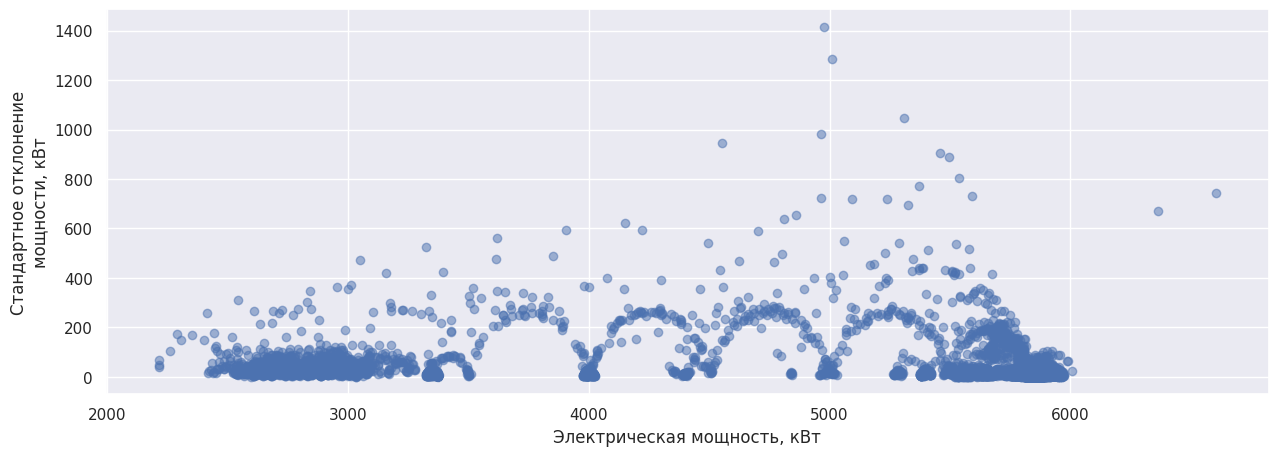

In [ ]:
plt.figure();
plt.scatter(useful_data['GTA1.DBinPU.P'], useful_data['power_std'], alpha=0.5);
plt.xlabel('Электрическая мощность, кВт');
plt.ylabel('Стандартное отклонение\nмощности, кВт');

Удалим данные с std больше 30

In [ ]:
useful_data = useful_data[useful_data['power_std'] < 30]
useful_data.shape

(1019581, 16)

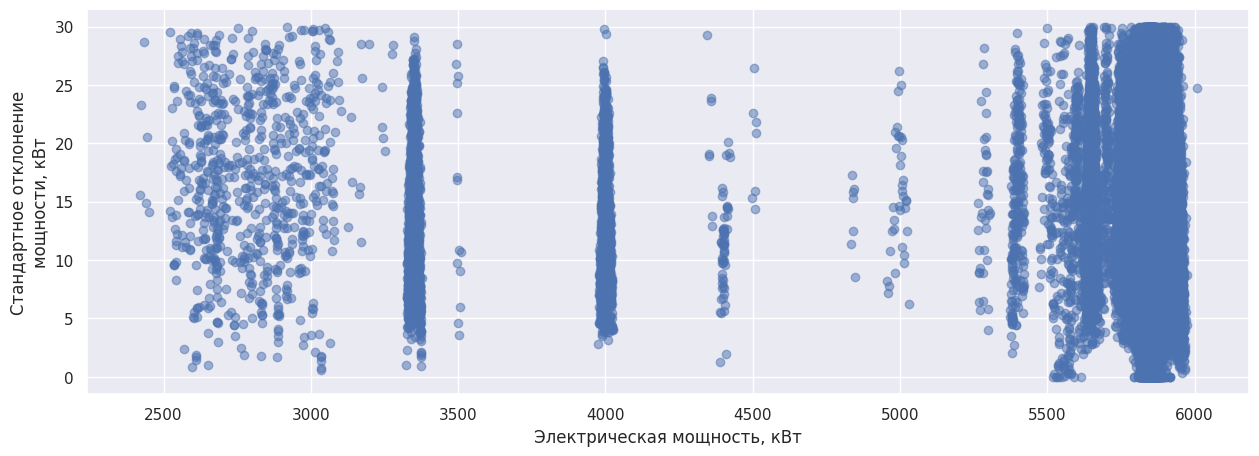

In [ ]:
plt.figure();
plt.scatter(useful_data['GTA1.DBinPU.P'], useful_data['power_std'], alpha=0.5);
plt.xlabel('Электрическая мощность, кВт');
plt.ylabel('Стандартное отклонение\nмощности, кВт');

По графику нетрудно выделить нагрузки, на которых установка какое-то время работала непрерывно. Основное число стационарных режимов находится в диапазоне электрических нагрузок больше 5500 кВт, что соответствует области номинальных нагрузок ГТУ.

Наибольшее влияние на режим эксплуатации газотурбинных установок оказывает заданная электрическая нагрузка и температура наружного воздуха.

Посмотрим на распределение наших данных относительно значения электрической мощности

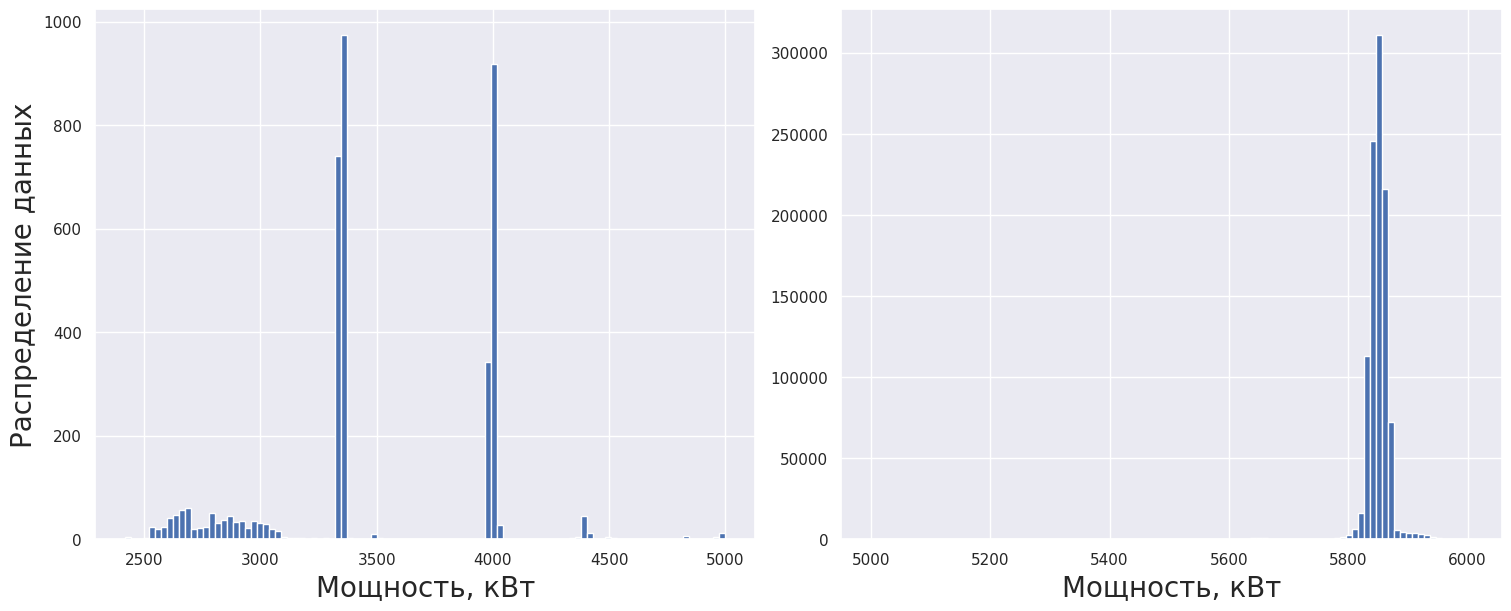

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), constrained_layout=True)
# fig.tight_layout()
ax1.hist(useful_data[useful_data['GTA1.DBinPU.P'] < 5000]['GTA1.DBinPU.P'], bins=100);
ax1.set_ylabel("Распределение данных", fontsize=20);
ax1.set_xlabel("Мощность, кВт", fontsize=20);
ax2.hist(useful_data[useful_data['GTA1.DBinPU.P'] > 5000]['GTA1.DBinPU.P'], bins=100);
ax2.set_xlabel("Мощность, кВт", fontsize=20);

Распределение данных относительно температуры наружного воздуха

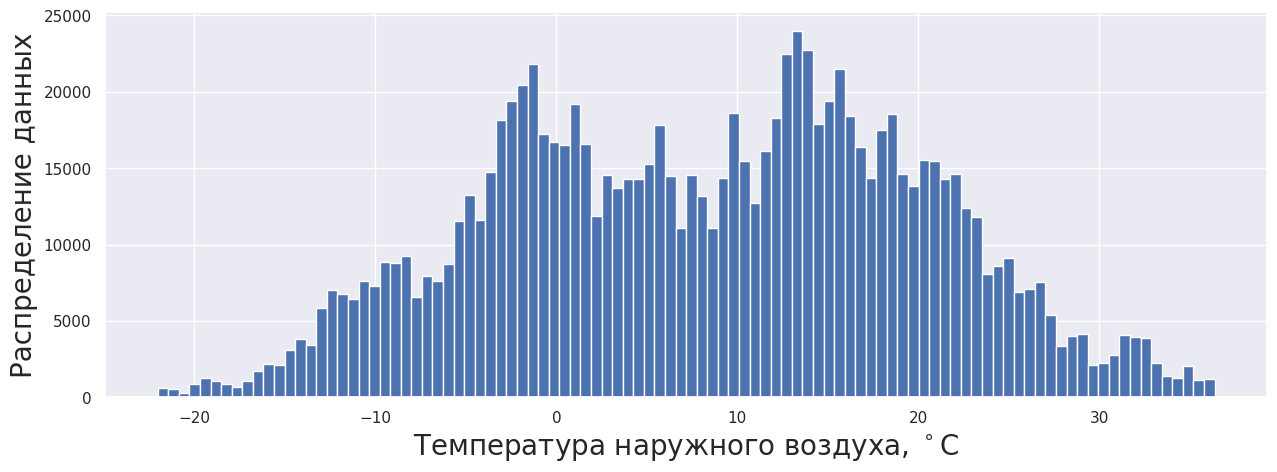

In [ ]:
plt.figure();
plt.hist(useful_data['GTA1.DBinPU.Tn'], bins=100);
plt.xlabel('Температура наружного воздуха, $^\\circ$С', fontsize=20);
plt.ylabel('Распределение данных', fontsize=20);

Основное количество данных сосредоточено в области номинальной нагрузки ГТУ (>5800кВт). Очевидно, что данные сильно не сбалансированы относительной электрической мощности. Обучение модели на несбалансированных данных может привести к тому, что точность модели будет выше в зоне номинальных электрических нагрузок по отношению к зоне пониженных нагрузок. В силу того, что в имеющихся у нас данных содержится очень много точек с номинальной электрической нагрузкой мы можем удалить часть этих данных для повышения сбалансированности всего набора. Разделим весь диапазон мощности, который присутствует в данные на участки по 50 МВт и сделаем так, что на каждом таком участке будет не более чем 1200 точек, выбор точек для удаления осуществялется случайным образом.

In [ ]:
# import warnings
# warnings.filterwarnings('ignore')

p_step = 50
for i in tqdm(range(1000, 6100, p_step)):
    useful_data.drop(index = useful_data[(useful_data['GTA1.DBinPU.P'] > i) & (useful_data['GTA1.DBinPU.P'] < (i + p_step))]
            .sample(frac=1).iloc[1200:,:].index, inplace=True)
useful_data.shape

100%|██████████| 102/102 [00:32<00:00,  3.15it/s]


(12935, 16)

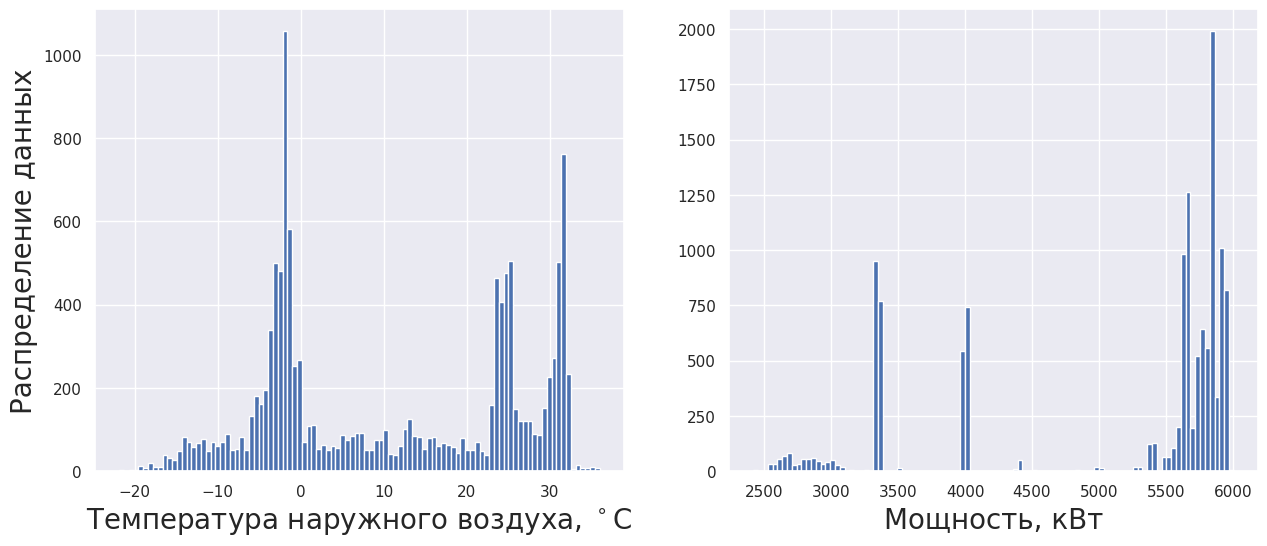

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
ax1.hist(useful_data['GTA1.DBinPU.Tn'], bins=100);
ax1.set_xlabel('Температура наружного воздуха, $^\\circ$С', fontsize=20);
ax1.set_ylabel('Распределение данных', fontsize=20);
ax2.hist(useful_data['GTA1.DBinPU.P'], bins=100);
ax2.set_xlabel("Мощность, кВт", fontsize=20);

Из новых гистограмм видно, что данные по прежнему не сбалансированны относительно электрической нагрузки, но теперь не сбалансированность существенно меньше.

Построим парную диаграмму признаков, которые относятся к внешним воздействиям для анализируемого объекта (ГТУ), к таким признакам относятся: электрическая нагрузка, температура наружного воздуха, атмосферное давление и относительная влажность наружного воздуха.

<Figure size 1500x500 with 0 Axes>

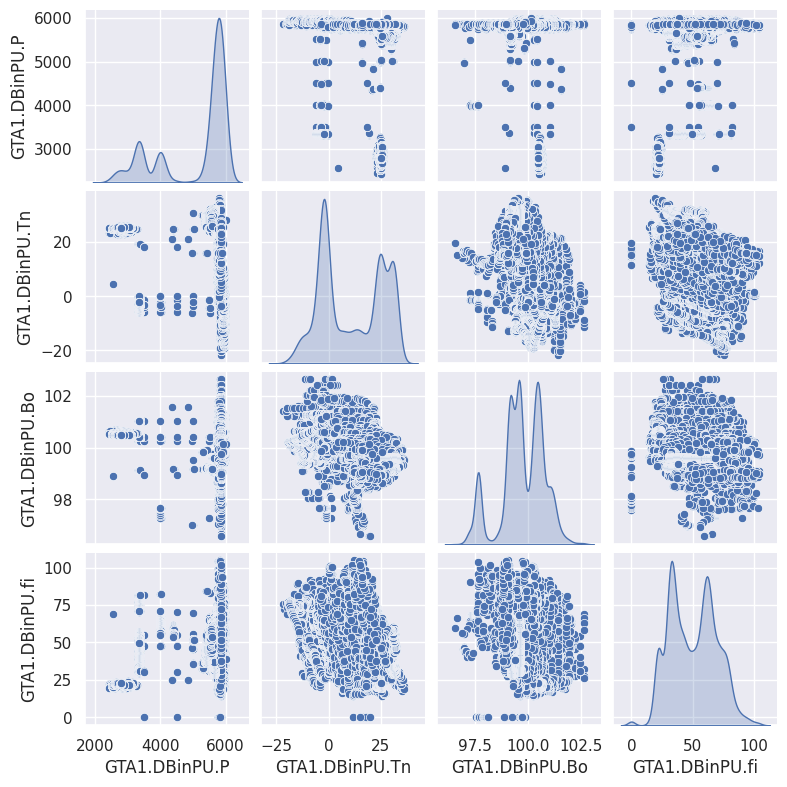

In [ ]:
# matplotlib.rc('xtick', labelsize=12)
# matplotlib.rc('ytick', labelsize=12)
act_features = [
    'GTA1.DBinPU.P', # электрическая нагрузка, определяется заданием
    'GTA1.DBinPU.Tn', # температура наружного воздуха
    'GTA1.DBinPU.Bo', # барометрическое давление
    'GTA1.DBinPU.fi' # относительная влажность наружного воздуха
];

fig = plt.figure();
# sns.set();
sns.pairplot(
    useful_data[act_features], height = 2,
    kind ='scatter',diag_kind='kde');

Видно, что данные покрывают весь рассматриваемый диапазон внешних параметров.

### Взаимная корреляция данных

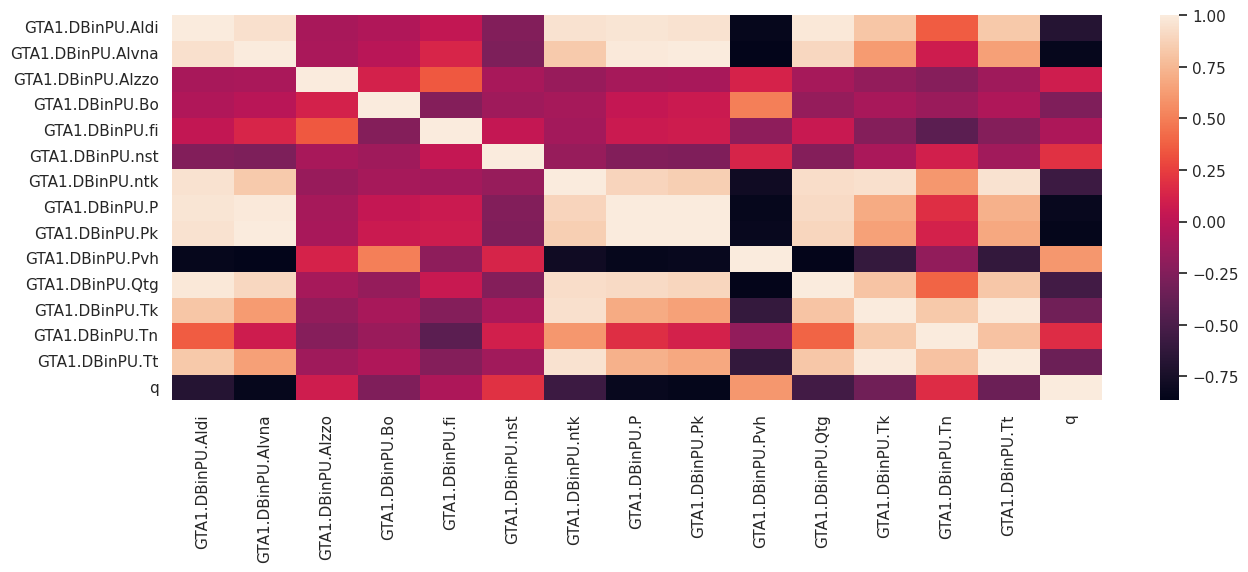

In [ ]:
data_correlation = useful_data[selected_params_kks].corr()
data_correlation.columns = selected_params_kks
data_correlation.index = selected_params_kks
sns.heatmap(data_correlation);

Рассчитаем отношение некоторых признаков с хорошей взаимной корреляцией и построим зависимости этих отношений от температуры наружного воздуха и электрической мощности.

Text(0.5, 0, 'GTA1.DBinPU.Tn')

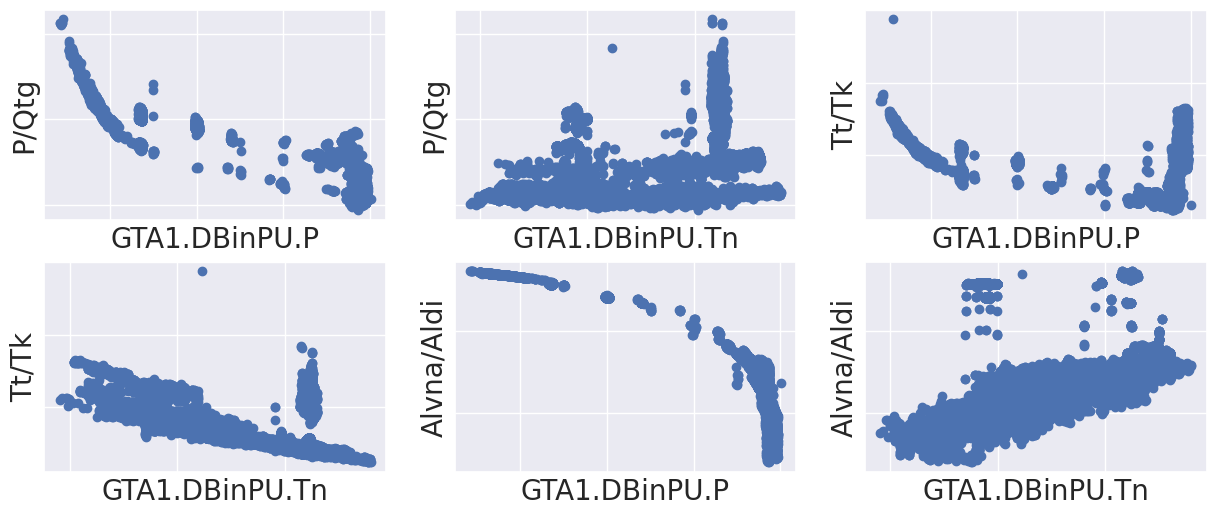

In [ ]:
matplotlib.rc('xtick', labelsize=20)
matplotlib.rc('ytick', labelsize=20)

useful_data['P_Qtg'] = useful_data['GTA1.DBinPU.Qtg'] / useful_data['GTA1.DBinPU.P']
useful_data['Tt_Tk'] = useful_data['GTA1.DBinPU.Tt'] / useful_data['GTA1.DBinPU.Tk']
useful_data['Alvna_Aldi'] = useful_data['GTA1.DBinPU.Aldi'] / useful_data['GTA1.DBinPU.Alvna']
useful_data['ntk_Aldi'] = useful_data['GTA1.DBinPU.ntk'] / useful_data['GTA1.DBinPU.Alvna']
useful_data['Pk_Alvna'] = useful_data['GTA1.DBinPU.Pk'] / useful_data['GTA1.DBinPU.Alvna']

fig, (
    (ax1, ax2, ax3),
    (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 6))

ax1.plot(useful_data['GTA1.DBinPU.P'], useful_data['P_Qtg'], 'bo',);
ax1.set_yticklabels([])
ax1.set_xticklabels([])
ax1.set_ylabel("P/Qtg", labelpad=-5, fontsize=20)
ax1.set_xlabel("GTA1.DBinPU.P", labelpad=-5, fontsize=20)
ax2.plot(useful_data['GTA1.DBinPU.Tn'], useful_data['P_Qtg'], 'bo');
ax2.set_yticklabels([])
ax2.set_xticklabels([])
ax2.set_ylabel("P/Qtg", labelpad=-5, fontsize=20)
ax2.set_xlabel("GTA1.DBinPU.Tn", labelpad=-5, fontsize=20)
ax3.plot(useful_data['GTA1.DBinPU.P'], useful_data['Tt_Tk'], 'bo');
ax3.set_yticklabels([])
ax3.set_xticklabels([])
ax3.set_ylabel("Tt/Tk", labelpad=-5, fontsize=20)
ax3.set_xlabel("GTA1.DBinPU.P", labelpad=-5, fontsize=20)
ax4.plot(useful_data['GTA1.DBinPU.Tn'], useful_data['Tt_Tk'], 'bo');
ax4.set_yticklabels([])
ax4.set_xticklabels([])
ax4.set_ylabel("Tt/Tk", labelpad=-5, fontsize=20)
ax4.set_xlabel("GTA1.DBinPU.Tn", labelpad=-5, fontsize=20)
ax5.plot(useful_data['GTA1.DBinPU.P'], useful_data['Alvna_Aldi'], 'bo');
ax5.set_yticklabels([])
ax5.set_xticklabels([])
ax5.set_ylabel("Alvna/Aldi", labelpad=-5, fontsize=20)
ax5.set_xlabel("GTA1.DBinPU.P", labelpad=-5, fontsize=20)
ax6.plot(useful_data['GTA1.DBinPU.Tn'], useful_data['Alvna_Aldi'], 'bo');
ax6.set_yticklabels([])
ax6.set_xticklabels([])
ax6.set_ylabel("Alvna/Aldi", labelpad=-5, fontsize=20)
ax6.set_xlabel("GTA1.DBinPU.Tn", labelpad=-5, fontsize=20)

На паре некоторых графиках заметны явно аномальные данные. Рассмотрим их подробнее.

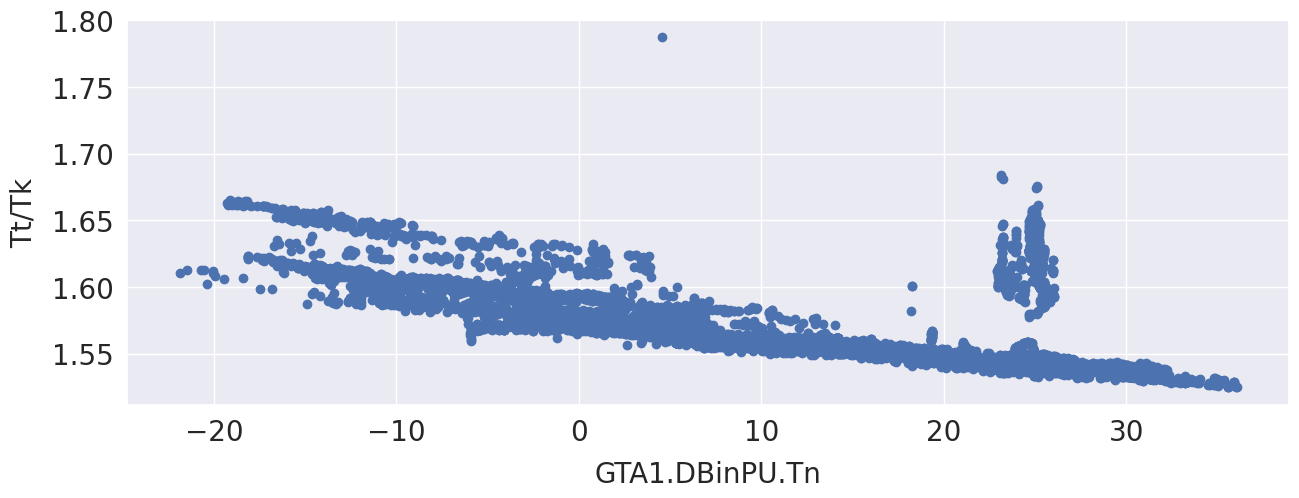

In [ ]:
plt.plot(useful_data['GTA1.DBinPU.Tn'], useful_data['Tt_Tk'], 'bo');
plt.ylabel("Tt/Tk", labelpad=10, fontsize=20)
plt.xlabel("GTA1.DBinPU.Tn", labelpad=10, fontsize=20);

# plt.ylim([1.64, 1.66]);

In [ ]:
useful_data = useful_data[useful_data['Tt_Tk'] < 1.75]
useful_data.shape

(12934, 21)

Оставшиеся данные в основном состоят из нормальных стационарных режимов, на их основе можно разработать модель поиска аномалий.

### Сохранение подготовленных данных

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
useful_data[selected_params_kks].to_parquet("/content/drive/MyDrive/SMOPA/data.gzip", compression='gzip')